# Advanced MVO - custom objectives
고급 MVO-맞춤형 목표

<!-- PyPortfolioOpt has implemented some of the most common objective functions (e.g `min_volatility`, `max_sharpe`, `max_quadratic_utility`, `efficient_risk`, `efficient_return`). However, sometimes yoy may have an idea for a different objective function.

In this cookbook recipe, we cover:

- Mininimising transaction costs
- Custom convex objectives
- Custom nonconvex objectives -->

PyPortfolioOpt는 가장 일반적인 목적 함수 중 일부를 구현했습니다 (예 : `min_volatility`, `max_sharpe`, `max_quadratic_utility`, `efficient_risk`, `efficient_return`). 그러나 때로는 다른 목적 함수에 대한 아이디어가 있을 수 있습니다.

이 쿡북 레시피에서는 다음을 다룹니다.

- 거래 비용<sup>transaction costs</sup> 최소화
- 맞춤형 볼록 목표<sup>convex objectives</sup>
- 맞춤형 비볼록록 목표<sup>nonconvex objectives</sup>

## Acquiring data

<!-- As discussed in the previous notebook, assets are an exogenous input (i.e you must come up with a list of tickers). We will use `yfinance` to download data for thesee tickers -->

이전 노트북에서 설명했듯이 자산은 외생적 입력입니다(즉, 티커 목록을 작성해야 함). `yfinance`를 사용하여 티커에 대한 데이터를 다운로드합니다.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tickers = ["BLK", "BAC", "AAPL", "TM", "WMT",
           "JD", "INTU", "MA", "UL", "CVS",
           "DIS", "AMD", "NVDA", "PBI", "TGT"]

In [6]:
ohlc = yf.download(tickers, end='2020-09-01')#period="max")

[*********************100%***********************]  15 of 15 completed


In [7]:
prices = ohlc["Adj Close"]
prices.tail()

,AAPL,AMD,BAC,BLK,CVS,DIS,INTU,JD,MA,NVDA,PBI,TGT,TM,UL,WMT
Date,,,,,,,,,,,,,,,
2020-08-25,124.610016,86.349998,25.820137,587.620605,62.936012,129.789993,335.827362,78.970001,347.255646,509.847473,6.196672,152.220764,134.789993,59.679874,130.630005
2020-08-26,126.304596,86.019997,25.383181,588.564880,62.172489,132.179993,341.736908,80.379997,350.611694,510.767212,5.928976,152.081345,134.889999,59.798878,130.699997
2020-08-27,124.794701,83.800003,25.869791,591.427673,62.856682,133.729996,344.392212,79.300003,355.585938,504.978912,5.879403,149.691208,133.559998,59.898048,136.630005
2020-08-28,124.592552,85.550003,26.118061,597.471436,62.678196,135.539993,345.500244,79.959999,365.694153,525.752686,5.790171,150.229004,133.919998,59.650124,140.300003
2020-08-31,128.817749,90.820000,25.561935,590.642456,61.597366,131.869995,344.781555,78.639999,357.773376,534.819946,5.443157,150.587524,132.429993,59.084862,138.850006


## Expected returns and risk models

<!-- In this notebook, we will use James-Stein shrinkage and semicovariance (which only penalises downside risk). -->

이 노트북에서는 James-Stein 수축 및 반공분산<sup>semicovariance</sup> (하방 위험만 불이익)을 사용합니다.

In [8]:
import pypfopt
pypfopt.__version__

'1.2.7'

In [9]:
from pypfopt import risk_models, expected_returns
from pypfopt import plotting

mu = expected_returns.capm_return(prices)
S = risk_models.semicovariance(prices)

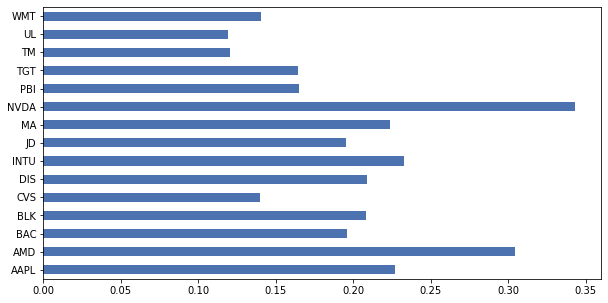

In [10]:
mu.plot.barh(figsize=(10,5));

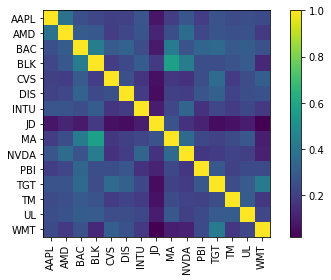

In [11]:
plotting.plot_covariance(S, plot_correlation=True);

## Min volatility with a transaction cost objective

<!-- Let's say that you already have a portfolio, and want to now optimise it. It could be quite expensive to completely reallocate, so you may want to take into account transaction costs. PyPortfolioOpt provides a simple objective to account for this.

Note: this objective will not play nicely with `max_sharpe`. -->

이미 포트폴리오를 보유하고 있고, 이를 최적화하려고 한다고 가정해 보겠습니다. 완전히 재 할당하려면 비용이 많이 들 수 있으므로 거래 비용을 고려할 수 있습니다. PyPortfolioOpt는 이를 설명하기 위한 간단한 목표를 제공합니다.

참고:이 목표는 `max_sharpe`에서 제대로 작동하지 않습니다.

In [12]:
# Pretend that you started with a default-weight allocation
initial_weights = np.array([1/len(tickers)] * len(tickers))

In [13]:
from pypfopt import EfficientFrontier, objective_functions

ef = EfficientFrontier(mu, S)

# 1% broker commission
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01)
ef.min_volatility()
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.06667),
             ('AMD', 0.0),
             ('BAC', 0.0626),
             ('BLK', 0.06667),
             ('CVS', 0.06667),
             ('DIS', 0.06667),
             ('INTU', 0.06667),
             ('JD', 0.1374),
             ('MA', 0.06667),
             ('NVDA', 0.06667),
             ('PBI', 0.06667),
             ('TGT', 0.06667),
             ('TM', 0.06667),
             ('UL', 0.06667),
             ('WMT', 0.06667)])

<!-- Notice that many of the weights are 0.06667, i.e your original equal weight. In fact, the only change has been an allocation of AMD's weight to JD. If we lower the cost `k`, the allocation will change more: -->

많은 가중치가 0.06667입니다. 즉, 원래 동일한 가중치입니다. 사실 유일한 변화는 AMD의 가중치를 JD에 할당하는 것입니다. 비용 `k`를 낮추면 할당이 더 많이 변경됩니다.

In [14]:
ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.001)
ef.min_volatility()
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.00047),
             ('AMD', 0.0),
             ('BAC', 0.0),
             ('BLK', 0.06667),
             ('CVS', 0.06423),
             ('DIS', 0.0445),
             ('INTU', 0.02921),
             ('JD', 0.43452),
             ('MA', 0.10516),
             ('NVDA', 0.0),
             ('PBI', 0.0146),
             ('TGT', 0.02615),
             ('TM', 0.06667),
             ('UL', 0.08116),
             ('WMT', 0.06667)])

<!-- The optimiser seems to really like JD. The reason for this is that it is highly anticorrelated to other assets (notice the dark column in the covariance plot). Hence, historically, it adds a lot of diversification. But it is dangerous to place too much emphasis on what happened in the past, so we may want to limit the asset weights.  -->

옵티마이저는 JD를 정말 좋아하는 것 같습니다. 그 이유는 다른 자산과 상관관계가 매우 높기 때문입니다(공분산도의 어두운 열에 주목). 따라서 역사적으로 많은 다양성을 추가합니다. 그러나 과거에 일어난 일을 너무 강조하는 것은 위험하므로 자산 가중치를 제한 할 수 있습니다.

<!-- In addition, we notice that 4 stocks have now been allocated zero weight, which may be undesirable. Both of these problems can be fixed by adding an [L2 regularisation objective](https://pyportfolioopt.readthedocs.io/en/latest/EfficientFrontier.html#more-on-l2-regularisation).  -->

또한 현재 4 개의 주식에 0 가중치가 할당되어 바람직하지 않을 수 있습니다. 이 두 문제는 [L2 정규화 목표](https://pyportfolioopt.readthedocs.io/en/latest/EfficientFrontier.html#more-on-l2-regularisation)를 추가하여 해결할 수 있습니다.

In [15]:
ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.001)
ef.add_objective(objective_functions.L2_reg)
ef.min_volatility()
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.06363),
             ('AMD', 0.05814),
             ('BAC', 0.0632),
             ('BLK', 0.06801),
             ('CVS', 0.06725),
             ('DIS', 0.06667),
             ('INTU', 0.06639),
             ('JD', 0.07366),
             ('MA', 0.0701),
             ('NVDA', 0.06381),
             ('PBI', 0.0666),
             ('TGT', 0.06664),
             ('TM', 0.06855),
             ('UL', 0.06913),
             ('WMT', 0.06822)])

<!-- This has had too much of an evening-out effect. After all, if the resulting allocation is going to be so close to equal weights, we may as well stick with our initial allocation. We can reduce the strength of the L2 regularisation by reducing `gamma`: -->

이것은 evening-out effect에 너무 많은 영향을 미쳤습니다. 결국 결과 할당이 동일한 가중치에 너무 가깝다면 초기 할당을 고수하는 것이 좋습니다. `gamma`를 줄임으로써 L2 정규화의 강도를 줄일 수 있습니다.

In [16]:
ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.001)
ef.add_objective(objective_functions.L2_reg, gamma=0.05)  # default is 1
ef.min_volatility()
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.03765),
             ('AMD', 0.0),
             ('BAC', 0.02106),
             ('BLK', 0.07589),
             ('CVS', 0.06667),
             ('DIS', 0.06638),
             ('INTU', 0.06052),
             ('JD', 0.15916),
             ('MA', 0.10662),
             ('NVDA', 0.0353),
             ('PBI', 0.0586),
             ('TGT', 0.06022),
             ('TM', 0.08333),
             ('UL', 0.09101),
             ('WMT', 0.07759)])

In [17]:
ef.portfolio_performance(verbose=True);

Expected annual return: 18.4%
Annual volatility: 8.1%
Sharpe Ratio: 2.02


<!-- This portfolio is now reasonably balanced, but also puts significantly more weight on JD.  -->

이 포트폴리오는 이제 합리적으로 균형을 이루지만 JD에 훨씬 더 많은 비중을 둡니다.

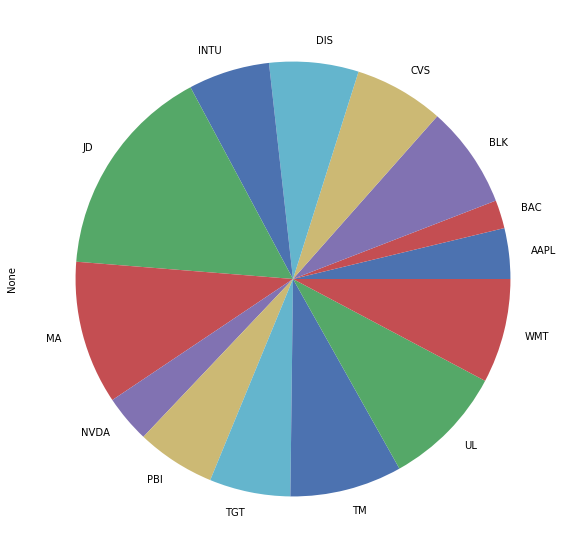

In [18]:
pd.Series(weights).plot.pie(figsize=(10,10));

## Custom convex objectives
<!-- 
PyPortfolioOpt comes with the following built-in objective functions, as of v1.2.1:

- Portfolio variance (i.e square of volatility)
- Portfolio return
- Sharpe ratio
- L2 regularisation (minimising this reduces nonzero weights)
- Quadratic utility
- Transaction cost model (a simple one)
 -->
PyPortfolioOpt는 v1.2.1부터 다음과 같은 내장 목적 함수와 함께 제공됩니다.

- 포트폴리오 분산 (즉, 변동성의 제곱)
- 포트폴리오 수익률
- 샤프 비율
- L2 정규화 (최소화하면 0이 아닌 가중치 감소)
- 2차 유틸리티
- 거래 비용 모델 (간단한 모델)

<!-- However, you may want have a different objective. If this new objective is **convex**, you can optimise a portfolio with the full benefit of PyPortfolioOpt's modular syntax, for example adding other constraints and objectives. -->

그러나 다른 목표를 원할 수 있습니다. 이 새로운 목표가 **볼록(convex)** 한 경우 PyPortfolioOpt의 모듈식 구문을 최대한 활용하여 포트폴리오를 최적화 할 수 있습니다(예 : 다른 제약 조건 및 목표 추가).


<!-- To demonstrate this, we will minimise the **logarithmic-barrier** function suggested in the paper 60 Years of Portfolio Optimisation, by Kolm et al (2014): -->

이를 증명하기 위해 Kolm 등(2014)이 작성한 60 Years of Portfolio Optimisation 논문에서 제안한 **logarithmic-barrier** 함수를 최소화 할 것입니다.

$$f(w, S, k) = w^T S w - k \sum_{i=1}^N \ln w$$

<!-- We must first convert this mathematical objective into the language of cvxpy. Cvxpy is a powerful modelling language for convex optimisation problems. It is clean and easy to use, the only caveat is that objectives must be expressed with `cvxpy` functions, a list of which can be found [here](https://www.cvxpy.org/tutorial/functions/index.html). -->

먼저 이 수학적 목표를 cvxpy의 언어로 변환해야합니다. Cvxpy는 볼록 최적화 문제를 위한 강력한 모델링 언어입니다. 깨끗하고 사용하기 쉽습니다. 유일한 주의점은 목표는 cvxpy 함수로 표현되어야한다는 것입니다. 목록은 [여기](https://www.cvxpy.org/tutorial/functions/index.html)에서 찾을 수 있습니다.

In [19]:
import cvxpy as cp

# Note: functions are minimised. If you want to maximise an objective, stick a minus sign in it.
def logarithmic_barrier_objective(w, cov_matrix, k=0.1):
    log_sum = cp.sum(cp.log(w))
    var = cp.quad_form(w, cov_matrix)
    return var - k * log_sum

<!-- Once we have written the objective function, we can just use the `ef.convex_objective()` to minimise the objective. -->

목적 함수를 작성했으면 `ef.convex_objective()`를 사용하여 목적을 최소화 할 수 있습니다.

In [20]:
ef = EfficientFrontier(mu, S, weight_bounds=(0.01, 0.2))
ef.convex_objective(logarithmic_barrier_objective, cov_matrix=S, k=0.001)
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.0452),
             ('AMD', 0.03304),
             ('BAC', 0.04233),
             ('BLK', 0.0686),
             ('CVS', 0.06373),
             ('DIS', 0.05807),
             ('INTU', 0.0547),
             ('JD', 0.16711),
             ('MA', 0.0888),
             ('NVDA', 0.04477),
             ('PBI', 0.05471),
             ('TGT', 0.0553),
             ('TM', 0.07356),
             ('UL', 0.07871),
             ('WMT', 0.07137)])

In [21]:
ef.portfolio_performance(verbose=True);

Expected annual return: 19.1%
Annual volatility: 8.5%
Sharpe Ratio: 2.00


<!-- This is compatible with all the constraints discussed in the previous recipe. Let's say that we want to limit JD's weight to 15%. -->

이는 이전 레시피에서 논의 된 모든 제약 조건과 호환됩니다. JD의 가중치를 15%로 제한한다고 가정해 보겠습니다.

In [22]:
ef = EfficientFrontier(mu, S, weight_bounds=(0.01, 0.2))
jd_index = ef.tickers.index("JD")  # get the index of JD
ef.add_constraint(lambda w: w[jd_index] <= 0.15)
ef.convex_objective(logarithmic_barrier_objective, cov_matrix=S, k=0.001)
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.04571),
             ('AMD', 0.03325),
             ('BAC', 0.04269),
             ('BLK', 0.07029),
             ('CVS', 0.06497),
             ('DIS', 0.05901),
             ('INTU', 0.0556),
             ('JD', 0.15),
             ('MA', 0.09221),
             ('NVDA', 0.04536),
             ('PBI', 0.05564),
             ('TGT', 0.05611),
             ('TM', 0.07534),
             ('UL', 0.08087),
             ('WMT', 0.07294)])

## Custom nonconvex objectives

<!-- In some cases, you may be trying to optimise for nonconvex objectives. Optimisation in general is a very hard problem, so please be aware that you may have mixed results in that case. Convex problems, on the other hand, are well understood and can be solved with nice theoretical guarantees. -->

경우에 따라 볼록하지 않은 목표를 최적화하려고 할 수 있습니다. 일반적으로 최적화는 매우 어려운 문제이므로 이 경우 결과가 혼합 될 수 있습니다. 반면에 볼록 문제는 잘 이해되고 이론적으로 훌륭한 보증을 통해 해결할 수 있습니다.

<!-- PyPortfolioOpt does offer some functionality for nonconvex optimisation, but it is not really encouraged. In particular, nonconvex optimisation is not compatible with PyPortfolioOpt's modular constraints API. -->

PyPortfolioOpt는 비볼록 최적화를 위한 일부 기능을 제공하지만 실제로 권장하지는 않습니다. 특히 비볼록 최적화는 PyPortfolioOpt의 모듈 식 제약 API와 호환되지 않습니다.

<!-- As an example, we will use the Deviation Risk Parity objective from Kolm et al (2014). Because we are not using a convex solver, we don't have to define it using `cvxpy` functions. -->

예를 들어 Kolm 등 (2014)의 편차 위험 패리티 목표<sup>Deviation Risk Parity objective</sup>를 사용합니다. 볼록 해결자<sup>solver</sup>를 사용하지 않기 때문에 `cvxpy` 함수를 사용하여 정의 할 필요가 없습니다.

In [23]:
def deviation_risk_parity(w, cov_matrix):
    diff = w * np.dot(cov_matrix, w) - (w * np.dot(cov_matrix, w)).reshape(-1, 1)
    return (diff ** 2).sum().sum()

In [24]:
ef = EfficientFrontier(mu, S, weight_bounds=(0.01, 0.12))
ef.nonconvex_objective(deviation_risk_parity, ef.cov_matrix)
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.05854),
             ('AMD', 0.03286),
             ('BAC', 0.05895),
             ('BLK', 0.07272),
             ('CVS', 0.07206),
             ('DIS', 0.06983),
             ('INTU', 0.06756),
             ('JD', 0.07463),
             ('MA', 0.07473),
             ('NVDA', 0.05965),
             ('PBI', 0.06875),
             ('TGT', 0.06875),
             ('TM', 0.07349),
             ('UL', 0.07412),
             ('WMT', 0.07336)])

<!-- However, let's say we now want to enforce that JD has a weight of 10%. In the convex case, this would be as simple as: -->
그러나 이제 JD가 10%의 가중치를 갖도록 강제하려고 한다고 가정해 보겠습니다. 볼록한 경우 다음과 같이 간단합니다.

```python
ef.add_objective(lambda w: w[jd_index] == 0.10)
```

<!-- But unfortunately it is not so simple for PyPortfolioOpt's nonconvex optimisation. Constraints should be passed using the `scipy` syntax. This means you need to rearrange your constraints to make them either `=0` or `<= 0`.  -->

그러나 불행히도 PyPortfolioOpt의 비볼록 최적화는 그렇게 간단하지 않습니다. 제약 조건은 `scipy` 구문을 사용하여 전달해야합니다. 즉, 제약 조건을 `=0` 또는 `<= 0`으로 만들기 위해 재정렬해야 합니다.

```python
constraints = [
    # First constraint
     {"type": "eq",  # equality constraint,
      "fun": lambda w: w[1] - 0.2},  # the equality functions are assumed to = 0 
      
    # Second constraint
    {"type": "ineq",  # inequality constraint
     "fun": lambda w: w[0] - 0.5}   # inequality functions <= 0
]
```

<!-- For more information, you can consult the [scipy docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html), but they aren't very helpful. -->

자세한 내용은 [scipy 문서](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)를 참조 할 수 있지만 그다지 도움이 되지는 않습니다.

In [25]:
ef = EfficientFrontier(mu, S, weight_bounds=(0.01, 0.12))

ef.nonconvex_objective(
    deviation_risk_parity,
    objective_args=S,
    weights_sum_to_one=True,
    constraints=[
        {"type": "eq", "fun": lambda w: w[jd_index] - 0.10},  
    ],
)

weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.06409),
             ('AMD', 0.06339),
             ('BAC', 0.06411),
             ('BLK', 0.06446),
             ('CVS', 0.06444),
             ('DIS', 0.06439),
             ('INTU', 0.06433),
             ('JD', 0.1),
             ('MA', 0.06451),
             ('NVDA', 0.06412),
             ('PBI', 0.06436),
             ('TGT', 0.06436),
             ('TM', 0.06448),
             ('UL', 0.06449),
             ('WMT', 0.06447)])

## More examples of nonconvex objectives

<!-- The scipy format is not intuitive and is hard to explain, so here are a bunch of examples (adapted from the tests). Some of these are actually convex, so you should use `convex_objective` instead.  -->

scipy 형식은 직관적이지 않고 설명하기 어렵기 때문에 여기에 여러 예제가 있습니다(테스트에서 채택됨). 이들 중 일부는 실제로 볼록하므로 `convex_objective`를 대신 사용해야합니다.

In [26]:
# Another example of deviation risk parity
def deviation_risk_parity(w, cov_matrix):
    n = cov_matrix.shape[0]
    rp = (w * (cov_matrix @ w)) / cp.quad_form(w, cov_matrix)
    return cp.sum_squares(rp - 1 / n).value

ef = EfficientFrontier(mu, S)
ef.nonconvex_objective(deviation_risk_parity, ef.cov_matrix)
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.04463),
             ('AMD', 0.03246),
             ('BAC', 0.04173),
             ('BLK', 0.06834),
             ('CVS', 0.06341),
             ('DIS', 0.05762),
             ('INTU', 0.05417),
             ('JD', 0.17191),
             ('MA', 0.08906),
             ('NVDA', 0.04414),
             ('PBI', 0.0542),
             ('TGT', 0.05479),
             ('TM', 0.07345),
             ('UL', 0.07885),
             ('WMT', 0.07123)])

In [27]:
# Deviation risk parity with weight bound on the first asset
ef = EfficientFrontier(mu, S)
ef.nonconvex_objective(deviation_risk_parity, 
                       ef.cov_matrix, 
                       constraints=[{"type":"eq", "fun":lambda w: w[0] - 0.1}])
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.1),
             ('AMD', 0.03428),
             ('BAC', 0.04728),
             ('BLK', 0.07117),
             ('CVS', 0.06565),
             ('DIS', 0.06036),
             ('INTU', 0.05601),
             ('JD', 0.09988),
             ('MA', 0.0864),
             ('NVDA', 0.04806),
             ('PBI', 0.05947),
             ('TGT', 0.05733),
             ('TM', 0.07087),
             ('UL', 0.07494),
             ('WMT', 0.06829)])

In [28]:
# Market-neutral efficient risk.
# Please use ef.efficient_risk() for anything serious.
target_risk = 0.19
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))

# Weights sum to zero
weight_constr = {"type": "eq", "fun": lambda w: np.sum(w)}

# Portfolio vol less than target vol
risk_constr = {
    "type": "eq",
    "fun": lambda w: target_risk ** 2 - np.dot(w.T, np.dot(ef.cov_matrix, w)),
}
constraints = [weight_constr, risk_constr]

ef.nonconvex_objective(
    lambda w, mu: -w.T.dot(mu),  # min negative return i.e max return
    objective_args=(ef.expected_returns),
    weights_sum_to_one=False,
    constraints=constraints,
)
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.09243),
             ('AMD', 0.16881),
             ('BAC', 0.00164),
             ('BLK', -0.14501),
             ('CVS', -0.19388),
             ('DIS', 0.21401),
             ('INTU', 0.11244),
             ('JD', 0.14436),
             ('MA', 0.66951),
             ('NVDA', 0.44258),
             ('PBI', -0.07308),
             ('TGT', 0.00018),
             ('TM', -0.52697),
             ('UL', -0.74008),
             ('WMT', -0.16695)])

In [29]:
# Utility objective - you could actually use ef.max_quadratic_utility
ef = EfficientFrontier(mu, S)

def utility_obj(weights, mu, cov_matrix, k=1):
    return -weights.dot(mu) + k * np.dot(weights.T, np.dot(cov_matrix, weights))

ef.nonconvex_objective(
    utility_obj,
    objective_args=(ef.expected_returns, ef.cov_matrix, 1)
    # default is for weights to sum to 1
)

weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.0),
             ('AMD', 0.08998),
             ('BAC', 0.0),
             ('BLK', 0.0),
             ('CVS', 0.0),
             ('DIS', 0.0),
             ('INTU', 0.0),
             ('JD', 0.0),
             ('MA', 0.0),
             ('NVDA', 0.91002),
             ('PBI', 0.0),
             ('TGT', 0.0),
             ('TM', 0.0),
             ('UL', 0.0),
             ('WMT', 0.0)])

In [30]:
ef.weights.sum()

1.0000000000000002

In [31]:
# Kelly objective with weight bounds on zeroth asset
def kelly_objective(w, e_returns, cov_matrix, k=3):
    variance = np.dot(w.T, np.dot(cov_matrix, w))
    objective = variance * 0.5 * k - np.dot(w, e_returns)
    return objective

lower_bounds, upper_bounds = 0.01, 0.3
ef = EfficientFrontier(mu, S)
ef.nonconvex_objective(
    kelly_objective,
    objective_args=(ef.expected_returns, ef.cov_matrix, 1000),
    constraints=[
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},
        {"type": "ineq", "fun": lambda w: w[0] - lower_bounds},
        {"type": "ineq", "fun": lambda w: upper_bounds - w[0]},
    ],
)

weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.06667),
             ('AMD', 0.06667),
             ('BAC', 0.06667),
             ('BLK', 0.06667),
             ('CVS', 0.06667),
             ('DIS', 0.06667),
             ('INTU', 0.06667),
             ('JD', 0.06667),
             ('MA', 0.06667),
             ('NVDA', 0.06667),
             ('PBI', 0.06667),
             ('TGT', 0.06667),
             ('TM', 0.06667),
             ('UL', 0.06667),
             ('WMT', 0.06667)])